In [1]:
# Shaimae Elhajjajy
# February 26, 2024
# Run ArchR scRNA-seq integration on the 10X Multiome PBMC scATAC 10K data, but using results from anchoring analyses on tiles.
# Note! Run with singularity image archr_seuratv4.sif

In [1]:
# options(Seurat.object.assay.version = 'v3')

In [1]:
# Load libraries
library(ArchR)
library(Seurat)
library(SeuratObject)
library(SummarizedExperiment)
library(tidyverse)
library(patchwork)


                                                   / |
                                                 /    \
            .                                  /      |.
            \\\                              /        |.
              \\\                          /           `|.
                \\\                      /              |.
                  \                    /                |\
                  \\#####\           /                  ||
                ==###########>      /                   ||
                 \\##==......\    /                     ||
            ______ =       =|__ /__                     ||      \\\
        ,--' ,----`-,__ ___/'  --,-`-===================##========>
       \               '        ##_______ _____ ,--,__,=##,__   ///
        ,    __==    ___,-,__,--'#'  ==='      `-'    | ##,-/
        -,____,---'       \\####\\________________,--\\_##,/
           ___      .______        ______  __    __  .______      
          /   \     |   _ 

In [2]:
packageVersion("Seurat")
packageVersion("Matrix")
packageVersion("ggplot2")

[1] ‘4.3.0’

[1] ‘1.6.5’

[1] ‘3.4.4’

In [3]:
# Parameters
set.seed(99)
addArchRThreads(threads = 16)

Setting default number of Parallel threads to 16.



In [4]:
# Load in custom genome
library(BSgenome.GRCh38.ENCODE, lib.loc = "/data/zusers/elhajjajys/genomes/BSgenome/GRCh38")

Loading required package: BSgenome

Loading required package: Biostrings

Loading required package: XVector


Attaching package: ‘XVector’


The following object is masked from ‘package:purrr’:

    compact


The following object is masked from ‘package:plyr’:

    compact



Attaching package: ‘Biostrings’


The following object is masked from ‘package:grid’:

    pattern


The following object is masked from ‘package:base’:

    strsplit


Loading required package: BiocIO

Loading required package: rtracklayer


Attaching package: ‘rtracklayer’


The following object is masked from ‘package:BiocIO’:

    FileForFormat




In [5]:
# Set location of GENCODE annotation
GENOMES_DIR = "/data/zusers/elhajjajys/genomes"
GTF_BASE = "gencode.v40.basic.annotation"

In [6]:
# Read in blacklisted regions (i.e., exclusion set)
# Note: this is the official ENCODE blacklist for hg38, and is also built-in to Signac.
blacklist_df = fread(paste0(GENOMES_DIR, "/GRCh38.ENCODE.blacklist.ENCFF356LFX.bed"), sep = "\t")
colnames(blacklist_df) = c("chr", "start", "end")
blacklist_gr = makeGRangesFromDataFrame(blacklist_df, keep.extra.columns = TRUE)

In [7]:
# Create genome annotation (to infer chromosome sizes)
genomeAnnotation <- createGenomeAnnotation(genome = BSgenome.GRCh38.ENCODE, blacklist = blacklist_gr)

Getting genome..

Attempting to infer chromSizes..

Using provided blacklist...



In [8]:
# Create general gene reference (all genes)
genes_df = fread(paste0(GENOMES_DIR, "/", GTF_BASE, "/", GTF_BASE, ".gene.bed"), sep = "\t")
colnames(genes_df) = c("chr", "start", "end", "filler1", "filler2", "strand", "symbol", "gene_name", "gene_type", 
                       "transcript_id", "transcript_name", "transcript_type")
genes_gr = makeGRangesFromDataFrame(genes_df, keep.extra.columns = TRUE)

exons_df = fread(paste0(GENOMES_DIR, "/", GTF_BASE, "/", GTF_BASE, ".exon.bed"), sep = "\t")
colnames(exons_df) = c("chr", "start", "end", "filler1", "filler2", "strand", "symbol", "gene_name", "gene_type", 
                       "transcript_id", "transcript_name", "transcript_type")
exons_gr = makeGRangesFromDataFrame(exons_df, keep.extra.columns = TRUE)

tss_df = fread(paste0(GENOMES_DIR, "/", GTF_BASE, "/", GTF_BASE, ".TSS.bed"), sep = "\t")
colnames(tss_df) = c("chr", "start", "end", "filler1", "filler2", "strand", "symbol", "gene_name", "gene_type", 
                       "transcript_id", "transcript_name", "transcript_type")
tss_gr = makeGRangesFromDataFrame(tss_df, keep.extra.columns = TRUE)

geneAnnotation <- createGeneAnnotation(
  TSS = tss_gr,
  exons = exons_gr,
  genes = genes_gr
)

In [9]:
# Set directory where data is located
WORKING_DIR = "/zata/zippy/phanh/encode/snMultiome/adult_heart"
DATA_DIR = paste0(WORKING_DIR, "/snATAC/bams")
# Set output directory
OUT_DIR = paste0(WORKING_DIR, "/anchored_on_tiles_w_integration") 

In [10]:
# Read in ArchR object (from PBMC scMultiome 10K data, anchored on tiles)
proj = loadArchRProject(path = paste0(WORKING_DIR, "/anchored_on_tiles_w_integration/ArchROut"), force = TRUE, showLogo = FALSE)

Successfully loaded ArchRProject!



In [11]:
# View available matrices to see what is available (should only be GeneScoreMatrix and TileMatrix)
getAvailableMatrices(proj)

[1] "GeneScoreMatrix" "TileMatrix"

In [30]:
working_dir <- "/zata/zippy/phanh/encode/snMultiome/adult_heart"
data_dir = paste0(working_dir, "/snRNA")
# Set output directory
out_dir = paste0(working_dir, "")
sampleNames <- list.files(path = data_dir)
# sampleNames <- sub(".bam", "", sampleNames)
sampleNames
length(sampleNames)

[1] "heart.left.ventricle.ENCSR012APQ.ENCFF696DZL"               
 [2] "heart.left.ventricle.ENCSR405YKM.ENCFF718XQH"               
 [3] "heart.left.ventricle.ENCSR481QQR.ENCFF392PCC"               
 [4] "heart.left.ventricle.ENCSR727OYO.ENCFF518WAA"               
 [5] "heart.left.ventricle.ENCSR755CIF.ENCFF594SCL"               
 [6] "heart.right.ventricle.ENCSR060ZXZ.ENCFF757DCI"              
 [7] "heart.right.ventricle.ENCSR258SZI.ENCFF289QCB"              
 [8] "heart.right.ventricle.ENCSR426PDU.ENCFF038SVX"              
 [9] "left.cardiac.atrium.ENCSR463EEP.ENCFF546SAM"                
[10] "left.cardiac.atrium.ENCSR527MGL.ENCFF359TAG"                
[11] "left.cardiac.atrium.ENCSR700UVN.ENCFF991PTI"                
[12] "left.ventricle.myocardium.superior.ENCSR079LVG.ENCFF618DEA" 
[13] "Right.ventricle.myocardium.inferior.ENCSR151ONW.ENCFF619IBP"
[14] "Right.ventricle.myocardium.superior.ENCSR813PWQ.ENCFF816PKY"

[1] 14

In [31]:
rna_expID <- c('ENCSR012APQ','ENCSR405YKM',
                 'ENCSR481QQR','ENCSR727OYO',
                 'ENCSR755CIF','ENCSR060ZXZ',
                 'ENCSR258SZI','ENCSR426PDU',
                 'ENCSR463EEP','ENCSR527MGL',
                 'ENCSR700UVN','ENCSR079LVG',
                 'ENCSR151ONW','ENCSR813PWQ')
annotation_all <- read.table("/zata/zippy/phanh/encode/snMultiome/adult_heart/cell.types.snRNA.tsv", sep="\t", header=T)

In [32]:
# Load the ENCODE snRNA adult heart dataset
adult_heart_data <- list()
adult_heart <- list()

for (i in 1:length(sampleNames)) {
#    adult_heart_data <-  append(adult_heart_data, Read10X(data.dir = paste0(data_dir, "/", sampleNames[i], "/filtered/"), gene.column = 1))
    adult_heart <- append(adult_heart, CreateSeuratObject(counts = Read10X(data.dir = paste0(data_dir, "/", sampleNames[i], "/filtered/"), gene.column = 1), min.cells = 3, min.features = 200))
    annotation <- annotation_all %>% filter(rna_dataset == rna_expID[i])
    adult_heart[[i]]@meta.data$rna_barcode <- rownames(FetchData(adult_heart[[i]], "ident"))
    adult_heart[[i]]@meta.data <- distinct(left_join(adult_heart[[i]]@meta.data, annotation, by="rna_barcode"))
    adult_heart[[i]]@meta.data$rna_dataset <- rna_expID[i]
    adult_heart[[i]]@meta.data[["cell_type_name"]] <- factor(adult_heart[[i]]@meta.data[["cell_type_name"]])
    cell_type <- adult_heart[[i]]@meta.data[["cell_type_name"]]
    adult_heart[[i]]$cluster <- cell_type
    # adult_heart[[i]]$cluster
}
# adult_heart[1]

In [33]:
adult_heart_combined <- merge(adult_heart[[1]], y = adult_heart[2:length(sampleNames)], add.cell.ids = sampleNames)
adult_heart_combined

An object of class Seurat 
41925 features across 228811 samples within 1 assay 
Active assay: RNA (41925 features, 0 variable features)

In [25]:
# Read in the Seurat object
# seurat_object = readRDS(paste0(WORKING_DIR, "/anchored_on_tiles_w_integration/adult_heart_with_ctl_ENCSR258SZI.rds"))
# seurat_object = readRDS(paste0(WORKING_DIR, "/anchored_on_tiles_w_integration/adult_heart.rds"))

In [26]:
# seurat_object <- CreateSeuratObject(counts = seurat_object[['RNA']])

In [21]:
# adult_heart[["RNA"]] <- as(object = adult_heart@assays$RNA, Class = "Assay")

In [72]:
# Convert Seurat object to SummarizedExperiment object
seRNA = as.SingleCellExperiment(adult_heart_combined, assay = 'RNA')

In [73]:
# colnames(seRNA) <- adult_heart_combined@meta.data$rna_barcode
# class(rownames(seRNA))
# typeof(rownames(seRNA))
# # colnames(seRNA) <- as.character(colnames(seRNA))
seRNA

class: SingleCellExperiment 
dim: 41925 228811 
metadata(0):
assays(2): counts logcounts
rownames(41925): ENSG00000223972.5 ENSG00000227232.5 ...
  ENSG00000230066.5 ENSG00000234803.7
rowData names(0):
colnames(228811):
  heart.left.ventricle.ENCSR012APQ.ENCFF696DZL_AAACAGCCAAGGTACG
  heart.left.ventricle.ENCSR012APQ.ENCFF696DZL_AAACAGCCAATCGCAC ...
  Right.ventricle.myocardium.superior.ENCSR813PWQ.ENCFF816PKY_TTTGTTGGTTACAACG
  Right.ventricle.myocardium.superior.ENCSR813PWQ.ENCFF816PKY_TTTGTTGGTTGTTCAC
colData names(8): orig.ident nCount_RNA ... cluster ident
reducedDimNames(0):
mainExpName: RNA
altExpNames(0):

In [38]:
typeof(adult_heart_combined)

[1] "S4"

In [44]:
colnames(seRNA) <- rownames(adult_heart_combined@meta.data)

In [18]:
# # Unconstrained integration (preliminary)
# # A completely agnostic approach that would take all of the cells in your scATAC-seq experiment and attempt to align them 
# # to any of the cells in the scRNA-seq experiment.
# # Used to perform a more refined constrained integration.

# proj2 <- addGeneIntegrationMatrix(
#     ArchRProj = proj, 
#     useMatrix = "GeneScoreMatrix",
#     matrixName = "GeneIntegrationMatrix",
#     reducedDims = "IterativeLSI",
#     seRNA = seRNA,
#     addToArrow = FALSE,
#     groupRNA = "ident",
#     nameCell = "predictedCell_Un",
#     nameGroup = "predictedGroup_Un",
#     nameScore = "predictedScore_Un"
# )


In [45]:
proj3 <- addGeneIntegrationMatrix(
    ArchRProj = proj, 
    useMatrix = "GeneScoreMatrix",
    matrixName = "GeneIntegrationMatrix",
    reducedDims = "IterativeLSI",
    seRNA = seRNA,
    addToArrow = FALSE,
    groupRNA = "cluster",
    nameCell = "predictedCell_Un",
    nameGroup = "predictedGroup_Un",
    nameScore = "predictedScore_Un"
)

ArchR logging to : ArchRLogs/ArchR-addGeneIntegrationMatrix-22deee6cfefc99-Date-2024-07-01_Time-20-49-56.054062.log
If there is an issue, please report to github with logFile!

2024-07-01 20:49:56.11499 : Running Seurat's Integration Stuart* et al 2019, 0.001 mins elapsed.

2024-07-01 20:50:01.730559 : Checking ATAC Input, 0.095 mins elapsed.

2024-07-01 20:50:11.477023 : Checking RNA Input, 0.257 mins elapsed.

2024-07-01 20:51:59.535812 : Found 19767 overlapping gene names from gene scores and rna matrix!, 2.058 mins elapsed.

2024-07-01 20:51:59.548836 : Creating Integration Blocks, 2.058 mins elapsed.

2024-07-01 20:52:35.678365 : Prepping Interation Data, 2.66 mins elapsed.

2024-07-01 20:52:45.656233 : Computing Integration in 20 Integration Blocks!, 0 mins elapsed.

2024-07-01 21:05:07.949673 : Block (1 of 20) : Plotting Joint UMAP, 12.372 mins elapsed.

2024-07-01 21:05:43.202438 : Block (2 of 20) : Plotting Joint UMAP, 12.959 mins elapsed.

2024-07-01 21:06:15.548191 : Block (

In [46]:
# We will identify general cell types to provide a framework to further refine the integration results.
# Construct a confusion matrix to tell us which cell types from the scRNA-seq data are most abundant in each of the scATAC-seq clusters.
cM <- as.matrix(confusionMatrix(proj3$Clusters[proj3$predictedGroup_Un != "NA"], proj3$predictedGroup_Un[proj3$predictedGroup_Un != "NA"]))
preClust <- colnames(cM)[apply(cM, 1 , which.max)]
cbind(preClust, rownames(cM)) #Assignments

preClust,
cardiomyocyte,C6
cardiomyocyte,C3
fibroblast,C18
cardiomyocyte,C7
cardiomyocyte,C5
fibroblast,C24
fibroblast,C13
cardiomyocyte,C1
endocardial,C14
cardiomyocyte,C9


In [47]:
# Cell type labels from scRNA-seq data that were used in our unconstrained integration
sort(unique(proj3$predictedGroup_Un))

[1] "adipocyte"        "cardiomyocyte"    "endocardial"      "endothelial_cell"
 [5] "fibroblast"       "lymphocyte"       "macrophage"       "mast_cell"       
 [9] "mesothelial_cell" "NA"               "neuronal"         "pericyte"

In [102]:
# Convert Seurat object to SummarizedExperiment object
seRNA = as.SingleCellExperiment(adult_heart_combined, assay = 'RNA')
# colnames(seRNA) <- adult_heart_combined@meta.data$rna_barcode

In [108]:
# Create a string-based representation of fibroblast cells to use in the downstream constrained integration
cFib <- "fibroblast"
cSMC <- "smooth_muscle_cell"
cLymp <- "lymphocyte"
cPer <- "pericyte"
cEndoc <- "endocardial"
cMac <- "macrophage"
cCar <- "cardiomyocyte"
cAdi <- "adipocyte"
cEndot <- "endothelial_cell"
cMeso <- "mesothelial_cell"
cMast <- "mast_cell"
cNeu <- "neuronal"
cNon <- "NA"
table(colData(seRNA)$cluster)


         adipocyte      cardiomyocyte        endocardial   endothelial_cell 
               447              28254               1211               5177 
        fibroblast         lymphocyte         macrophage          mast_cell 
             13003                562               3888                171 
  mesothelial_cell           neuronal           pericyte smooth_muscle_cell 
               373                534               3101                752 

In [109]:
# Find the scATAC clusters that correspond to Fibroblast
clustFib <- rownames(cM)[grep(cFib, preClust)]
clustFib
clustPer <- rownames(cM)[grep(cPer, preClust)]
clustPer
clustEndoc <- rownames(cM)[grep(cEndoc, preClust)]
clustEndoc
clustMac <- rownames(cM)[grep(cMac, preClust)]
clustMac
clustLymp <- rownames(cM)[grep(cLymp, preClust)]
clustLymp
clustSMC <- rownames(cM)[grep(cSMC, preClust)]
clustSMC
clustCar <- rownames(cM)[grep(cCar, preClust)]
clustCar
clustAdi <- rownames(cM)[grep(cAdi, preClust)]
clustAdi
clustNeu <- rownames(cM)[grep(cNeu, preClust)]
clustNeu
clustEndot <- rownames(cM)[grep(cEndot, preClust)]
clustEndot
clustFPEMLS <- rownames(cM)[grep(paste0(cFib, "|", cPer, "|", cEndoc, "|", cMac, "|", cLymp, "|", cSMC), preClust)]
clustFPEMLS
clustNonFib <- rownames(cM)[grep(paste0(cPer, "|", cEndoc, "|", cMac, "|", cLymp, "|", cSMC, "|", cNon), preClust)]
clustNonFib
clustFibCar <- rownames(cM)[grep(paste0(cCar, "|" , cFib), preClust)]
clustNonFibCar <- rownames(cM)[grep(paste0(cPer, "|", cEndoc, "|", cMac, "|", cLymp, "|", cSMC, "|", 
                                           cAdi, "|", cNeu, "|", cEndot, "|", cMeso, "|", cMast, "|", "NA"), 
                                    preClust)]
# clustNon <- rownames(cM)[grep(cNon, preClust)]
# clustNon

[1] "C18" "C24" "C13" "C19" "C10" "C17" "C25"

[1] "C20"

[1] "C14" "C15" "C16"

[1] "C11"

[1] "C12"

character(0)

[1] "C6" "C3" "C7" "C5" "C1" "C9" "C8" "C2" "C4"

character(0)

character(0)

character(0)

[1] "C18" "C24" "C13" "C14" "C19" "C11" "C15" "C20" "C10" "C16" "C17" "C25"
[13] "C12"

[1] "C14" "C11" "C15" "C20" "C16" "C12"

In [110]:
# Find scRNA cell barcodes that belong to different cell types
rnaFib <- colnames(seRNA)[grep(cFib, colData(seRNA)$cluster)]
length(rnaFib)
rnaCar <- colnames(seRNA)[grep(cCar, colData(seRNA)$cluster)]
length(rnaCar)
rnaFibCar <- colnames(seRNA)[grep(paste0(cCar, "|" , cFib), colData(seRNA)$cluster)]
length(rnaFibCar)
rnaNonFibCar <- colnames(seRNA)[grep(paste0(cPer, "|", cEndoc, "|", cMac, "|", cLymp, "|", cSMC, "|", 
                                           cAdi, "|", cNeu, "|", cEndot, "|", cMeso, "|", cMast, "|", "NA"), 
                                     colData(seRNA)$cluster)]
length(rnaNonFibCar)
# rnaNonFib <- colnames(seRNA)[grep(cFib, colData(seRNA)$cluster)]
# length(rnaNonFib)
# rnaPer <- colnames(seRNA)[grep(cPer, colData(seRNA)$cluster)]
# length(rnaPer)
# rnaEndoc <- colnames(seRNA)[grep(cEndoc, colData(seRNA)$cluster)]
# length(rnaEndoc)
# rnaMac <- colnames(seRNA)[grep(cMac, colData(seRNA)$cluster)]
# length(rnaMac)
# rnaLymp <- colnames(seRNA)[grep(cLymp, colData(seRNA)$cluster)]
# length(rnaLymp)
# rnaSMC <- colnames(seRNA)[grep(cSMC, colData(seRNA)$cluster)]
# length(rnaSMC)
# rnaFPEMLS <- colnames(seRNA)[grep(paste0(cFib, "|", cPer, "|", cEndoc, "|", cMac, "|", cLymp, "|", cSMC), colData(seRNA)$cluster)]
# length(rnaFPEMLS)
rnaNonFib <- colnames(seRNA)[grep(paste0(cCar, "|", cPer, "|", cEndoc, "|", cMac, "|", cLymp, "|", cSMC, "|", cAdi, "|", cNeu, "|", cEndot, "|", "NA"), 
                                  colData(seRNA)$cluster)]
length(rnaNonFib)
rnaNon <- colnames(seRNA)[is.na(colData(seRNA)$cluster)]
length(rnaNon)

[1] 13003

[1] 28254

[1] 41257

[1] 16216

[1] 43926

[1] 171338

In [111]:
# # Create a nested list with the 2 groups we'd like to constrain
# # Contains lists of scRNA and scATAC barcodes belonging to the 2 groups, which will be used during the constrained integration.
groupList <- SimpleList(
    FibCar = SimpleList(
        ATAC = proj3$cellNames[proj3$Clusters %in% clustFibCar],
        RNA = rnaFibCar
    ),
    NonFibCar = SimpleList(
        ATAC = proj3$cellNames[proj3$Clusters %in% clustNonFibCar],
        RNA = rnaNonFibCar
    )    
)

In [112]:
# Perform the constrained integration
proj3 <- addGeneIntegrationMatrix(
    ArchRProj = proj3, 
    useMatrix = "GeneScoreMatrix",
    matrixName = "GeneIntegrationMatrix",
    reducedDims = "IterativeLSI",
    seRNA = seRNA,
    addToArrow = FALSE, 
    groupList = groupList,
    groupRNA = "cluster",
    nameCell = "predictedCell_Co",
    nameGroup = "predictedGroup_Co",
    nameScore = "predictedScore_Co"
)

ArchR logging to : ArchRLogs/ArchR-addGeneIntegrationMatrix-22deee5cfa239a-Date-2024-07-01_Time-22-01-33.613616.log
If there is an issue, please report to github with logFile!

2024-07-01 22:01:33.680521 : Running Seurat's Integration Stuart* et al 2019, 0.001 mins elapsed.

2024-07-01 22:01:39.087622 : Checking ATAC Input, 0.091 mins elapsed.

2024-07-01 22:01:47.163806 : Checking RNA Input, 0.226 mins elapsed.

2024-07-01 22:03:34.369703 : Found 19767 overlapping gene names from gene scores and rna matrix!, 2.013 mins elapsed.

2024-07-01 22:03:34.381101 : Creating Integration Blocks, 2.013 mins elapsed.

2024-07-01 22:03:40.243919 : Prepping Interation Data, 2.11 mins elapsed.

2024-07-01 22:03:49.869189 : Computing Integration in 20 Integration Blocks!, 0 mins elapsed.

2024-07-01 22:15:48.012715 : Block (1 of 20) : Plotting Joint UMAP, 11.969 mins elapsed.

2024-07-01 22:16:23.093363 : Block (2 of 20) : Plotting Joint UMAP, 12.554 mins elapsed.

2024-07-01 22:16:55.945747 : Block 

In [84]:
# Create a color palette
pal <- paletteDiscrete(values = colData(seRNA)$cluster)

ArchR logging to : ArchRLogs/ArchR-plotEmbedding-22deee58105ddd-Date-2024-07-01_Time-21-47-46.744025.log
If there is an issue, please report to github with logFile!

Getting UMAP Embedding

ColorBy = cellColData

Plotting Embedding

1 


ArchR logging successful to : ArchRLogs/ArchR-plotEmbedding-22deee58105ddd-Date-2024-07-01_Time-21-47-46.744025.log



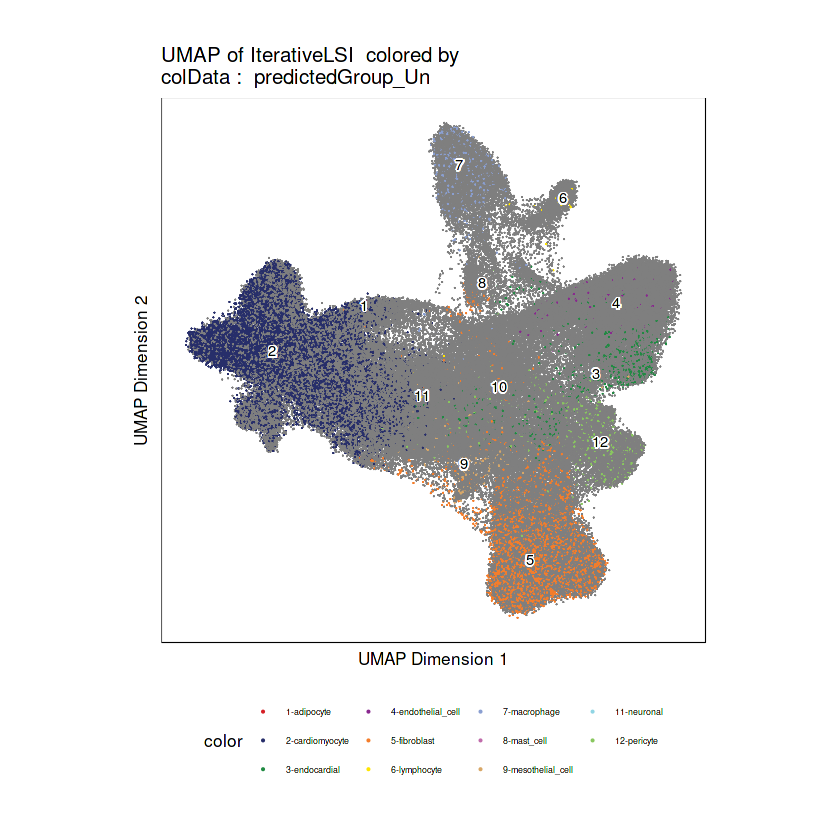

In [85]:
# Visualize results of unconstrained integration (i.e., overlay scRNA labels on scATAC cells)
p1 <- plotEmbedding(
    proj3, 
    colorBy = "cellColData", 
    name = "predictedGroup_Un", 
    pal = pal
)
p1

ArchR logging to : ArchRLogs/ArchR-plotEmbedding-22deee2aaa50fd-Date-2024-07-01_Time-22-26-36.409871.log
If there is an issue, please report to github with logFile!

Getting UMAP Embedding

ColorBy = cellColData

Plotting Embedding

1 


ArchR logging successful to : ArchRLogs/ArchR-plotEmbedding-22deee2aaa50fd-Date-2024-07-01_Time-22-26-36.409871.log



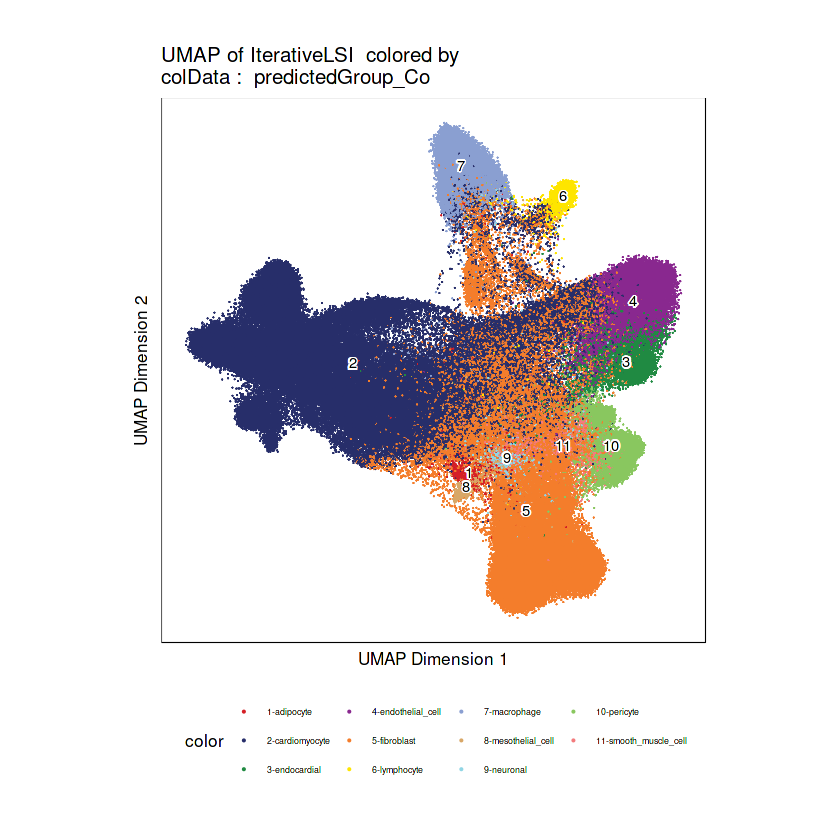

In [113]:
# Visualize results of constrained integration (i.e., overlay scRNA labels on scATAC cells)
p2 <- plotEmbedding(
    proj3, 
    colorBy = "cellColData", 
    name = "predictedGroup_Co", 
    pal = pal
)
p2

In [114]:
plotPDF(p1,p2, name = "Plot-UMAP-RNA-Integration.pdf", ArchRProj = proj3, addDOC = FALSE, width = 5, height = 5)

Plotting Ggplot!

Plotting Ggplot!



In [115]:
# Checkpoint! Save the ArchR project for easy loading next time
saveArchRProject(ArchRProj = proj3, outputDirectory = paste0(OUT_DIR, "/ArchROut_Integration"), load = FALSE)

Copying ArchRProject to new outputDirectory : /zata/zippy/phanh/encode/snMultiome/adult_heart/anchored_on_tiles_w_integration/ArchROut_Integration

Copying Arrow Files...

Copying Arrow Files (1 of 14)

Copying Arrow Files (2 of 14)

Copying Arrow Files (3 of 14)

Copying Arrow Files (4 of 14)

Copying Arrow Files (5 of 14)

Copying Arrow Files (6 of 14)

Copying Arrow Files (7 of 14)

Copying Arrow Files (8 of 14)

Copying Arrow Files (9 of 14)

Copying Arrow Files (10 of 14)

Copying Arrow Files (11 of 14)

Copying Arrow Files (12 of 14)

Copying Arrow Files (13 of 14)

Copying Arrow Files (14 of 14)

Getting ImputeWeights

Dropping ImputeWeights...

Copying Other Files...

Copying Other Files (1 of 18): Embeddings

Copying Other Files (2 of 18): ENCSR131DKN

Copying Other Files (3 of 18): ENCSR169BCG

Copying Other Files (4 of 18): ENCSR299NEP

Copying Other Files (5 of 18): ENCSR318ERF

Copying Other Files (6 of 18): ENCSR425CZQ

Copying Other Files (7 of 18): ENCSR491LSZ

Copying 

In [116]:
# Repeat, but this time add info to Arrow files
proj3 <- addGeneIntegrationMatrix(
    ArchRProj = proj3, 
    useMatrix = "GeneScoreMatrix",
    matrixName = "GeneIntegrationMatrix",
    reducedDims = "IterativeLSI",
    seRNA = seRNA,
    addToArrow = TRUE,
    force= TRUE,
    groupList = groupList,
    groupRNA = "cluster",
    nameCell = "predictedCell",
    nameGroup = "predictedGroup",
    nameScore = "predictedScore"
)

ArchR logging to : ArchRLogs/ArchR-addGeneIntegrationMatrix-22deee75704414-Date-2024-07-01_Time-22-27-57.808671.log
If there is an issue, please report to github with logFile!

2024-07-01 22:27:57.860748 : Running Seurat's Integration Stuart* et al 2019, 0.001 mins elapsed.

2024-07-01 22:28:04.73192 : Checking ATAC Input, 0.115 mins elapsed.

2024-07-01 22:28:15.289934 : Checking RNA Input, 0.291 mins elapsed.

2024-07-01 22:30:11.267891 : Found 19767 overlapping gene names from gene scores and rna matrix!, 2.224 mins elapsed.

2024-07-01 22:30:11.283004 : Creating Integration Blocks, 2.225 mins elapsed.

2024-07-01 22:30:16.743982 : Prepping Interation Data, 2.316 mins elapsed.

2024-07-01 22:30:28.152919 : Computing Integration in 20 Integration Blocks!, 0 mins elapsed.

2024-07-01 22:43:48.067621 : Block (1 of 20) : Plotting Joint UMAP, 13.332 mins elapsed.

2024-07-01 22:44:23.710289 : Block (2 of 20) : Plotting Joint UMAP, 13.926 mins elapsed.

2024-07-01 22:44:56.088213 : Block 

In [117]:
# Check that the GeneIntegrationMatrix has been added
getAvailableMatrices(proj3)

[1] "GeneIntegrationMatrix" "GeneScoreMatrix"       "TileMatrix"

In [118]:
# Add impute weights
proj3 <- addImputeWeights(proj3)

ArchR logging to : ArchRLogs/ArchR-addImputeWeights-22deee87be82c-Date-2024-07-01_Time-22-57-07.882395.log
If there is an issue, please report to github with logFile!

2024-07-01 22:57:08.042365 : Computing Impute Weights Using Magic (Cell 2018), 0 mins elapsed.



In [119]:
# Set known marker genes
markerGenes  <- c(
    # Fibroblast
    "DCN", "LUM", "PODN",
    # Macrophages
    "C1QB", "CD163", "MS4A7",
    # Endothelial
    "EGFL7", "CLDN5", "VWF",
    # Smooth muscle cells
    "GJA4", "FOXL1", "CARMN",
    # Vascular smooth muscle cells
    "FOXC2", "MYLK",
    # T lymphocytes
    "IFNG", "CD3D", "GZMA",
    # Schwann cells
    "S100B", "SOX10", "PLP1",
    # B lymphocytes
    "IGHJ6", "IGHA1", "IGHA2",
    # Mast cells
    "GATA1", "MRGPRX2", "HDC",
    # Mesothelial cells
    "HAS1", "WT1",
    # Adipocytes
    "ADIPOQ", "CIDEC", "LEP", "SLC36A2", "P2RX5", "UCP1", "CIDEA", "PRDM16", "LHX8", "EPSTI1", "MC2R", "FFAR2", "PIKFYVE", "CYP11B2",
    "TLR2", "TLR4", "ADRB1", "ADRB2", "ADRB3", "FABP4", "TNFRSF9", "TBX1", "TMEM26", "TCF21", "ADIPOQ", "CFD", "ACVR1C", "SLC2A4",
    "LPIN1", "PLIN1", "PCK1", "PPARG", "RETN", "MEST", "ADM2", "STAT6", "TFE3", "CPPED1", "SLC1A5", "ACSL1", "CAR3", "CAVIN1", "AGT",
    "BCAT2", "PNPLA2", "CIDEC", "CDO1", "APOC1", "MMP2", "POSTN", "LOX", "COL6A2", "ZBTB16", "GULP1", "FZD4", "TRIP10", "FGF7", "MAOB",
    "SOCS1", "NNMT", "AOC3", "H6PD", "CYP27A1", "EBF2", "MNDA", "HSD11B1", "AR", "GDF10", "CYP1B1", "STEAP4", "CCL11", "DEPTOR", "TUSC5",
    "FMO1", "ACADSB", "XDH", "PTGES", "CREB3L1", "ANGPTL2", "ADH1", "LBP", "NMB", "RARRES2", "EGFR", "CPXM1", "C3", "ADAMTS5", "MT2A",
    "METRN", "METRNL", "MYO1C", "NQO1", "AQP5", "TSPO", "AZGP1", "LRP1", "PDE3B", "LGALS12", "SERPINF1", "CPT1B", "ELOVL3", "PPARGC1A", 
    "MPZL1", "CITED1", "DPT", "HOXC9", "ZNF423", "ESM1",
    # Cardiomyocytes
    "TNNT2", "NKX2-5", "NPPA", "TNNC1", "ADM2", "ALCAM", "NPPA", "FGF2", "NPPB", "TNNI3", "TNNT2", "ANKRD1", "NPPC", "DES", "HAND2", "HAND1",
    "GATA4", "GATA6", "MYL2", "PNMT", "ACTA1", "CD36", "VLDLR", "ALPK3", "RBM24", "FABP4", "CKMT2", "MYH7B", "MYOM2", "PDLIM5", "MYH7", "PLN",
    "TCAP", "SORBS2", "RYR2", "ACTC1", "MYL3", "PDE3D", "NEXN", "FHL2", "MYBPC3", "MYH6", "TTN", "GPIHBP1", "AQP1", "DMD", "MFN2", "ASB2", "ART3",
    "RRAD", "JPH2", "HSPB7", "MYOZ2", "ENO3", "TRDN", "ACTN2", "TNNI1", "SMPX", "MYL7", "TBX20", "TRIM63", "MB", "CTGF", "MYL4", "LOX", "CTNNB1",
    "CPT1A", "SOX18", "NOTCH1", "SLN", "CSRP3", "TXLNB", "ATP2A2", "CKMT2", "CKB", "CXCR4", "IL11RA", "MITF", "ZFPM2", "BDNF", "GJA5", "FMOD",
    "MTTP", "SLC5A1", "ADIPOQ", "TRPV1", "HAMP", "SGPL1", "HMGB2", "STC1", "FGF23", "STRN", "HEY2", "ADIPOR1", "ADIPOR2", "PDE1A", "BMP4", "CASQ2", "TMP1",
    # Adipocytes progenitor cells
    "FGF10", "WT1", "SCARA5", "HOXC8", "TCF7L1", "HOXC9", "EBF2", "NRG4",
    # Cardiac stem and precursor cells
    "NKX2-5", "ISL1", "MESP1", "ADGRL2", "TBX3", "TBX4", "WNT5A", "ANKRD1"
    
    
    
  )
markerGenes = unique(markerGenes)
markerGenes_geneIDs = genes_df[genes_df$gene_name %in% markerGenes,]$symbol
markerGenes_geneIDs = markerGenes_geneIDs[!grepl("PAR_Y", markerGenes_geneIDs)]
head(markerGenes_geneIDs)
markerGenes_geneIDs_integration = markerGenes_geneIDs[markerGenes_geneIDs %in% getFeatures(ArchRProj = proj3, useMatrix = "GeneIntegrationMatrix", select = NULL, ignoreCase = TRUE)]
length(markerGenes_geneIDs)
length(getFeatures(ArchRProj = proj3, useMatrix = "GeneIntegrationMatrix", select = NULL, ignoreCase = TRUE))
length(markerGenes_geneIDs_integration)

[1] "ENSG00000142611.17" "ENSG00000049249.9"  "ENSG00000049239.13"
[4] "ENSG00000175206.11" "ENSG00000120937.9"  "ENSG00000116688.18"

[1] 231

[1] 19767

[1] 6

In [120]:
# Replot marker gene UMAP using Gene Expression from RNA
p1 <- plotEmbedding(
    ArchRProj = proj3, 
    colorBy = "GeneIntegrationMatrix", 
    name = markerGenes_geneIDs_integration, 
    continuousSet = "horizonExtra",
    embedding = "UMAP",
    imputeWeights = getImputeWeights(proj3)
)
# Replot marker gene UMAP using Gene Scores Matrix from ATAC
p2 <- plotEmbedding(
    ArchRProj = proj3, 
    colorBy = "GeneScoreMatrix", 
    continuousSet = "horizonExtra",
    name = markerGenes_geneIDs, 
    embedding = "UMAP",
    imputeWeights = getImputeWeights(proj3)
)

Getting ImputeWeights

ArchR logging to : ArchRLogs/ArchR-plotEmbedding-22deee36a31f9e-Date-2024-07-01_Time-23-01-20.86214.log
If there is an issue, please report to github with logFile!

Getting UMAP Embedding

ColorBy = GeneIntegrationMatrix

Getting Matrix Values...

2024-07-01 23:01:22.953163 : 



Imputing Matrix

Using weights on disk

Using weights on disk

Plotting Embedding

1 
2 
3 
4 
5 
6 


ArchR logging successful to : ArchRLogs/ArchR-plotEmbedding-22deee36a31f9e-Date-2024-07-01_Time-23-01-20.86214.log

Getting ImputeWeights

ArchR logging to : ArchRLogs/ArchR-plotEmbedding-22deee6d06fa9b-Date-2024-07-01_Time-23-02-47.096305.log
If there is an issue, please report to github with logFile!

Getting UMAP Embedding

ColorBy = GeneScoreMatrix

Getting Matrix Values...

2024-07-01 23:02:48.696199 : 



Imputing Matrix

Using weights on disk

Using weights on disk

Plotting Embedding

1 
2 
3 
4 
5 
6 
7 
8 
9 
10 
11 
12 
13 
14 
15 
16 
17 
18 
19 
20 
21 
22 
23 
24 
25 
26 


Warning message:
“The `<scale>` argument of `guides()` cannot be `FALSE`. Use "none" instead as of ggplot2 3.3.4.”


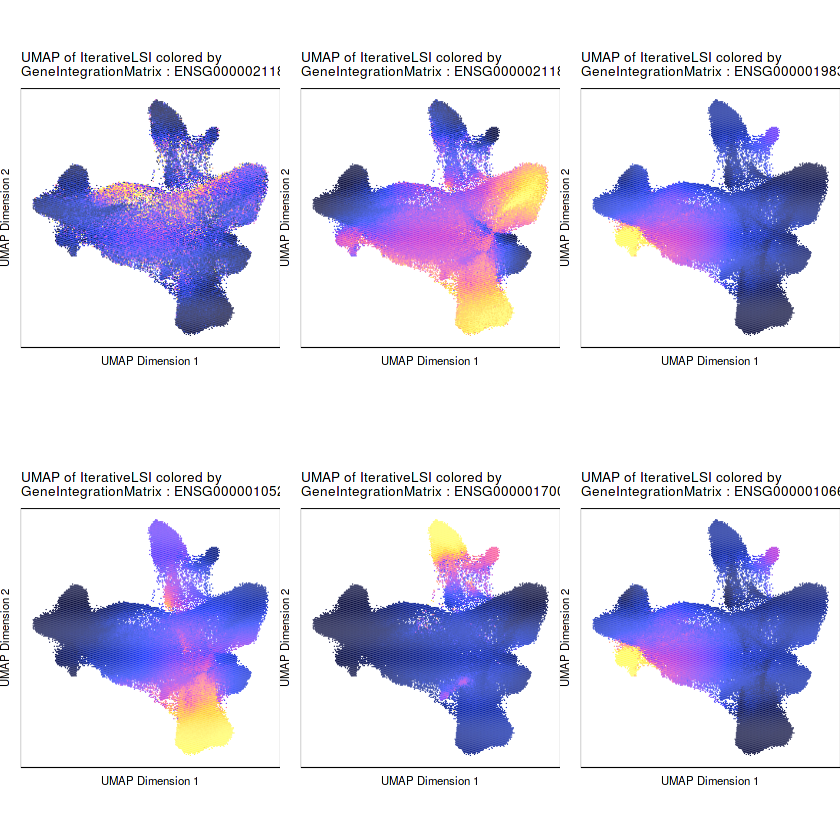

In [121]:
p1c <- lapply(p1, function(x){
    x + guides(color = FALSE, fill = FALSE) + 
    theme_ArchR(baseSize = 6.5) +
    theme(plot.margin = unit(c(0, 0, 0, 0), "cm")) +
    theme(
        axis.text.x=element_blank(), 
        axis.ticks.x=element_blank(), 
        axis.text.y=element_blank(), 
        axis.ticks.y=element_blank()
    )
})

p2c <- lapply(p2, function(x){
    x + guides(color = FALSE, fill = FALSE) + 
    theme_ArchR(baseSize = 6.5) +
    theme(plot.margin = unit(c(0, 0, 0, 0), "cm")) +
    theme(
        axis.text.x=element_blank(), 
        axis.ticks.x=element_blank(), 
        axis.text.y=element_blank(), 
        axis.ticks.y=element_blank()
    )
})

do.call(cowplot::plot_grid, c(list(ncol = 3), p1c))

In [122]:
plotPDF(plotList = p1, 
    name = "Plot-UMAP-Marker-Genes-RNA-W-Imputation.pdf", 
    ArchRProj = proj3, 
    addDOC = FALSE, width = 5, height = 5)

Plotting Ggplot!

Plotting Ggplot!

Plotting Ggplot!

Plotting Ggplot!

Plotting Ggplot!

Plotting Ggplot!



In [ ]:
# Create a confusion matrix between scATAC-seq clusters and the predictedGroup obtained from integration analysis
cM <- confusionMatrix(proj3$Clusters, proj3$predictedGroup)
labelOld <- rownames(cM)
labelOld

In [ ]:
# For each of scATAC-seq clusters, identify the cell type from predictedGroup which best defines that cluster
labelNew <- colnames(cM)[apply(cM, 1, which.max)]
labelNew

In [ ]:
# # Redefine cell type labels to a combined abbreviation that's easier to interpret
# cell_type_key = fread(paste0(WORKING_DIR, "/seurat/cluster_labels.txt"), sep = "\t", header = FALSE)
# colnames(cell_type_key) = c("cluster", "cell_type", "abbreviation", "label")
# remapClust <- labelNew
# remapClust

In [ ]:
# # Convert labels
# labelNew2 <- mapLabels(labelNew, oldLabels = remapClust$label, newLabels = remapClust$abbreviation)
# labelNew2

In [ ]:
# # Create new cluster labels in the project
# proj3$Clusters2 <- mapLabels(proj3$Clusters, newLabels = labelNew2, oldLabels = labelOld)

ArchR logging to : ArchRLogs/ArchR-plotEmbedding-245fc3613632f7-Date-2024-02-26_Time-10-29-56.278574.log
If there is an issue, please report to github with logFile!

Getting UMAP Embedding

ColorBy = cellColData

Plotting Embedding

1 


ArchR logging successful to : ArchRLogs/ArchR-plotEmbedding-245fc3613632f7-Date-2024-02-26_Time-10-29-56.278574.log



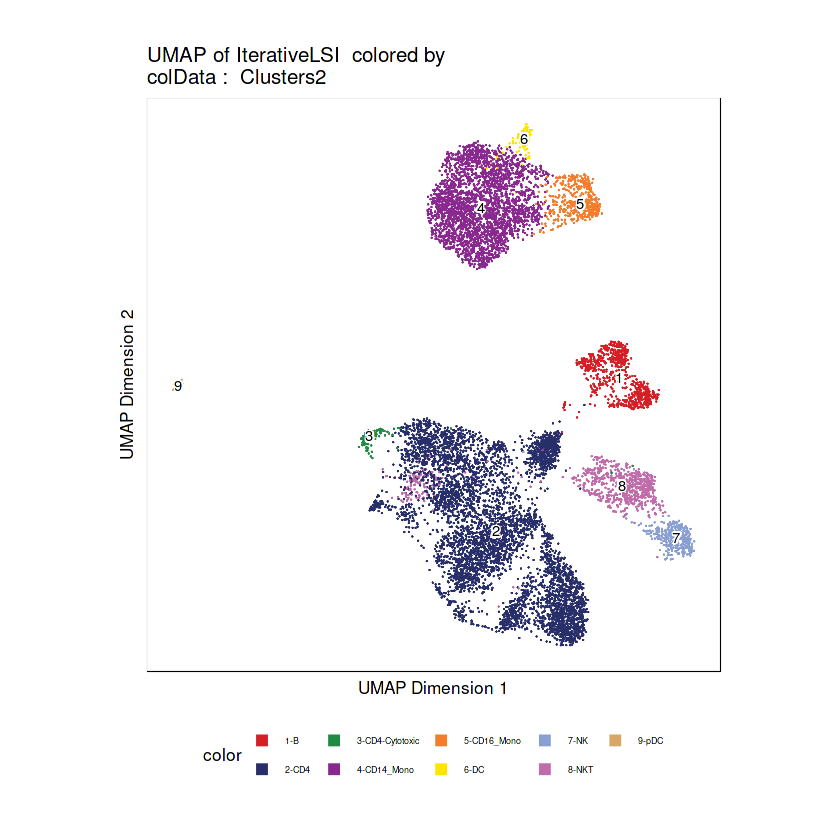

In [44]:
# # Plot the umap with new labels
# p1 <- plotEmbedding(proj3, colorBy = "cellColData", name = "Clusters2")
# p1

In [45]:
# plotPDF(p1, name = "Plot-UMAP-Remap-Clusters.pdf", ArchRProj = proj3, addDOC = FALSE, width = 5, height = 5)

Plotting Ggplot!



In [46]:
# Checkpoint! Save the ArchR project for easy loading next time
saveArchRProject(ArchRProj = proj3, outputDirectory = paste0(OUT_DIR, "/ArchROut_Integration"), load = FALSE)

Copying ArchRProject to new outputDirectory : /data/zusers/elhajjajys/networks/PBMC_scMultiome_10K/anchored_on_tiles_w_integration/ArchROut_Integration

Copying Arrow Files...

Copying Arrow Files (1 of 1)

Getting ImputeWeights

Dropping ImputeWeights...

Copying Other Files...

Copying Other Files (1 of 5): Embeddings

Copying Other Files (2 of 5): IterativeLSI

Copying Other Files (3 of 5): pbmc_scMultiome_atac_10k

Copying Other Files (4 of 5): Plots

Copying Other Files (5 of 5): RNAIntegration

Saving ArchRProject...

